In [1]:
!git clone https://github.com/Mike030668/Project_glass.git -q
!pip install backtesting -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# imports

In [2]:
import sys
dir_glass = '/content/Project_glass'
sys.path.append(dir_glass)

# модули и функции проекта glass
from prepare_data.constants import GLASS_COLS, FUTURE, MAIN_COLS, DEPTH, PREDICT_LAG, BATCH_SIZE, MAKE_LOG_VOL
from prepare_data.const_predprice import  TARGET_COLS, BASE_COLS, MAKE_LOG_TARGET
from prepare_data.utils import future_sequence, split_sequence, clean_dataset
from scripts.bots import cond_long, cond_short, long_Short
from scripts.robotest import prepare_data, making_signals
from scripts.stratagy import Long_Strategy, Short_Strategy, Long_n_Short_Strategy

from backtesting import Backtest # Библиотеки backtesting
import tensorflow as tf  # библиотека машинного обучения
import pandas as pd # библиотека пандас
import numpy as np # библиотека нампи
import joblib
from tqdm.notebook import tqdm   # отрисовка прохождения цикла
import warnings # библиотека сообщений по ошибкам
warnings.filterwarnings("ignore") # игнорировать сообщения ошибок

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


## Готовим производные данных

In [3]:
all_data = pd.read_csv(dir_glass + "/stock_data/BTCUSDT_1 _min.csv",
                       index_col=0, parse_dates=True )
print(f'Размер данных {all_data.shape}')

# колонки для тренировочной выборки сетки тренда
TREND_PRED_COLS = MAIN_COLS + GLASS_COLS

# колонки для тренировочной выборки сетки цены
PRICE_PRED_COLS = BASE_COLS + GLASS_COLS

# N колонки где начинается стакан
GLASS = len(GLASS_COLS)


# скейлеры для сетки тренда
x_trend_main_scr = joblib.load(dir_glass + "/predtrend/x_main_scailer.save")
x_trend_glass_scr = joblib.load("/content/Project_glass/predtrend/x_glass_scailer.save")
trend_scalers = [x_trend_main_scr, x_trend_glass_scr]
# скейлеры для сетки цены
x_price_main_scr = joblib.load(dir_glass + "/predprice/x_main_scailer.save")
x_price_glass_scr = joblib.load(dir_glass + "/predprice/x_glass_scailer.save")
y_price_scr = joblib.load(dir_glass + "/predprice/y_scailer.save")
price_scalers = [x_price_main_scr, x_price_glass_scr, y_price_scr]

Размер данных (8317, 54)


# Nets

In [4]:
# сетки
trend_model =  tf.keras.models.load_model(dir_glass + "/predtrend/model_gen")
price_model =  tf.keras.models.load_model(dir_glass + "/predprice/model_gen")


# Пример теста 1-го бота по ТЗ

- Вход лонг:

      Покупаем когда текущая позиция 0 (ничего не куплено) И :
      Сетка 1 показывает все пять предсказаний выше текущей цены И
      Сетка 2 изменила состояние Флэт или Падение на Рост по всем пяти минутам.

- Выход из лонга:

      Продаем позицию если
      Сетка 1 показывает 1е и 5е предсказания ниже текущей цены И
      Сетка 2 изменила состояние на Падение на по 1й и 5й минуте.

      После выхода проверяем условие на вход в позицию. (Т.к. на одной итерации могут сложиться условия и для выхода из лонга и для входа в шорт сразу)

- Вход шорт:

      Продаем когда текущая позиция 0 (ничего не продано) И :
      Сетка 1 показывает все пять предсказаний ниже текущей цены И
      Сетка 2 изменила состояние Флэт или Рост на Падение по всем пяти минутам.

- Выход из шорта:

      Продаем позицию если
      Сетка 1 показывает 1е и 5е предсказания выше текущей цены И
      Сетка 2 изменила состояние на Рост на по 1й и 5й минуте.

      После выхода проверяем условие на вход в позицию.
__________________________________

**Добавлено приземление цены**

корректируем ли цену сравнивая прошлое и текцщее 2 варианта:
- `pred_price` по разнице предскаханий с шага t и t-1
- `cur_price` по разнице предскахания с текущей;

In [7]:
FUTURE = 3000

# длина взгляда назад
BACK = DEPTH + PREDICT_LAG
TEST_SIZE = 3000
# данные назад
past_data =  all_data[FUTURE-BACK : FUTURE - PREDICT_LAG].copy()

# тестируемы датафрейм
test_data = all_data[FUTURE-PREDICT_LAG : FUTURE + TEST_SIZE].copy()

# получаем датафрейм с сигналом
df_test_signal = making_signals(past_data,
                                test_data,
                                # функция управления с сигналом по индексам
                                fun_action = long_Short(
                                          action = "mix",      # mix = long_Short
                                          # long индексы [0,1,2,3,4]
                                          lg_id_pr_up = [0, 1, 2], # id предсказаний выше текущей цены
                                          lg_id_tr_up = [0], # Рост по id
                                          lg_id_pr_lw = [0, 1, 2], # id предсказаний ниже текущей цены
                                          lg_id_tr_lw = [0], # Падение по id
                                          # short индексы [0,1,2,3,4]
                                          sh_id_pr_up = [0, 1, 2], # id предсказаний выше текущей цены
                                          sh_id_tr_up = [0], # Рост по id
                                          sh_id_pr_lw = [0, 1, 2], # id предсказаний ниже текущей цены
                                          sh_id_tr_lw = [0], # Падение по id
                                          # приземляем ли предсказание и как
                                          correct_price = "Aleksei" # "Michal" # False
                                ),

                                pred_lag = PREDICT_LAG,
                                glass = GLASS,
                                depth = DEPTH,
                                make_log_vol = MAKE_LOG_VOL,
                                make_log_tgt = MAKE_LOG_TARGET,
                                model_price = price_model,
                                model_trend = trend_model,
                                scalers_price = price_scalers,
                                scalers_trend = trend_scalers,
                                features_price = PRICE_PRED_COLS,
                                features_trend = TREND_PRED_COLS,
                                show_unique_signals = True
                                )

Пробегаемся по всем отсчетам:   0%|          | 0/3000 [00:00<?, ?step/s]

[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[-1, -1]
[1, 0]
[1, 0]
[1, 0]
[0, 1]
[0, 1]
[-1, -1]
[-1, -1]
[0, 1]
[1, 0]
[0, 1]
[-1, -1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[-1, -1]
[-1, -1]
[-1, -1]
[-1, -1]
[0, 1]
[0, 1]


In [ ]:
#path_file_name = "....."
#df_test_signal.to_csv(path_file_name, sep='\t', encoding='utf-8')

## Совмещенный график предсказаний



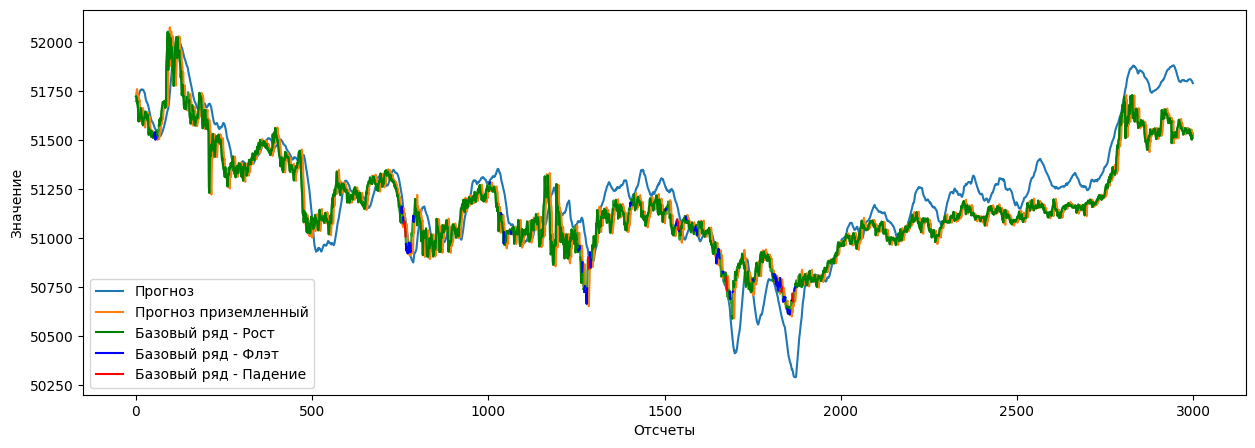

In [8]:
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
y_pred_earth = df_test_signal["pred_earth_price"].astype(float).to_numpy()
y_pred = df_test_signal["pred_price"].astype(float).to_numpy()
y_true = df_test_signal["Close"].to_numpy()

# pred_trend
y_pred_trend = df_test_signal["pred_trend"].astype(int).to_numpy()
down = (y_pred_trend == -1)
flat = (y_pred_trend == 0)
gross = (y_pred_trend == 1)

# смещаем на 1 вперед чтобы совместить педсказания завтра с реальной ценой на завтра
plt.figure(figsize=(15,5))
plt.plot(y_pred, label=f'Прогноз')
plt.plot(y_pred_earth, label=f'Прогноз приземленный')


plt.plot(y_true[1:])
plt.plot(np.where(gross[1:], y_true[1:], None), color="green", label= 'Базовый ряд - Рост')
plt.plot(np.where(flat[1:], y_true[1:], None), color="blue", label= 'Базовый ряд - Флэт')
plt.plot(np.where(down[1:], y_true[1:], None), color="red", label= 'Базовый ряд - Падение')

plt.xlabel('Отсчеты')
plt.ylabel(f'Значение')
plt.legend()
plt.show()


# Backtest

## Short_Strategy

In [9]:
CAPITAL = 100000
COMIS = 0.0002

# Стратегия
bt = Backtest(df_test_signal, Short_Strategy, cash= CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Текущий капитал  100000
______________________________________________
вход в продажу
Прибыль/убыток (позиции в деньгах 0
Прибыль/убыток позиции в % 0.0
position.is_long False
position.is_short False
______________________________________________

Текущий капитал  100026
______________________________________________
Закрытие позиции
Размер позиции -1
Прибыль/убыток (позиции в деньгах 25.575340000003052
Прибыль/убыток позиции в % 0.0005003678575370429
position.is_long False
position.is_short True
______________________________________________

Текущий капитал  100026
______________________________________________
вход в продажу
Прибыль/убыток (позиции в деньгах 0
Прибыль/убыток позиции в % 0.0
position.is_long False
position.is_short False
______________________________________________

Текущий капитал  100097
______________________________________________
Закрытие позиции
Размер позиции -1
Прибыль/убыток (позиции в деньгах 71.58084000000235
Прибыль/убыток позиции в % 0.001401194599787

Start                     2024-02-22 19:00:00
End                       2024-02-24 21:06:00
Duration                      2 days 02:06:00
Exposure Time [%]                        24.1
Equity Final [$]                  100217.3779
Equity Peak [$]                  100447.47534
Return [%]                           0.217378
Buy & Hold Return [%]               -0.406021
Return (Ann.) [%]                   30.237485
Volatility (Ann.) [%]                1.529055
Sharpe Ratio                        19.775273
Sortino Ratio                             inf
Calmar Ratio                        57.328785
Max. Drawdown [%]                    -0.52744
Avg. Drawdown [%]                   -0.176312
Max. Drawdown Duration        1 days 04:45:00
Avg. Drawdown Duration        0 days 03:24:00
# Trades                                    4
Win Rate [%]                            100.0
Best Trade [%]                       0.138945
Worst Trade [%]                      0.050037
Avg. Trade [%]                    

## Long_Strategy

In [10]:
CAPITAL = 100000

# Стратегия Long
bt = Backtest(df_test_signal, Long_Strategy, cash= CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Текущий капитал  100000
______________________________________________
вход в покупку
orders  (<Order size=1.0, contingent=0>,)
______________________________________________

Текущий капитал  100073
______________________________________________
Закрытие позиции
Размер позиции 1
Прибыль/убыток (позиции в деньгах 73.19750000000204
Прибыль/убыток позиции в % 0.0014346064871808561
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  100073
______________________________________________
вход в покупку
orders  (<Order size=1.0, contingent=0>,)
______________________________________________

Текущий капитал  99905
______________________________________________
Закрытие позиции
Размер позиции 1
Прибыль/убыток (позиции в деньгах -168.16481999999814
Прибыль/убыток позиции в % -0.0033080997747376717
position.is_long True
position.is_short False
______________________________________________



Start                     2024-02-22 19:00:00
End                       2024-02-24 21:06:00
Duration                      2 days 02:06:00
Exposure Time [%]                   25.733333
Equity Final [$]                  99904.93268
Equity Peak [$]                   100298.1975
Return [%]                          -0.095067
Buy & Hold Return [%]               -0.406021
Return (Ann.) [%]                  -10.927564
Volatility (Ann.) [%]                1.144357
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.653352
Avg. Drawdown [%]                   -0.150153
Max. Drawdown Duration        1 days 06:36:00
Avg. Drawdown Duration        0 days 03:21:00
# Trades                                    2
Win Rate [%]                             50.0
Best Trade [%]                       0.143265
Worst Trade [%]                      -0.33081
Avg. Trade [%]                    

## Long_n_Short_Strategy

In [11]:
CAPITAL = 100000

# Стратегия Long_Short
bt = Backtest(df_test_signal, Long_n_Short_Strategy, cash= CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Текущий капитал  100000
______________________________________________
вход в продажу
orders  (<Order size=-1.0, contingent=0>,)
______________________________________________

Текущий капитал  100026
______________________________________________
Закрытие позиции
Размер позиции -1
Прибыль/убыток (позиции в деньгах 25.575340000003052
Прибыль/убыток позиции в % 0.0005003678575370429
position.is_long False
position.is_short True
______________________________________________

Текущий капитал  100026
______________________________________________
вход в продажу
orders  (<Order size=-1.0, contingent=0>,)
______________________________________________

Текущий капитал  100097
______________________________________________
Закрытие позиции
Размер позиции -1
Прибыль/убыток (позиции в деньгах 71.58084000000235
Прибыль/убыток позиции в % 0.00140119459978727
position.is_long False
position.is_short True
______________________________________________

Текущий капитал  100097
_____________________

Start                     2024-02-22 19:00:00
End                       2024-02-24 21:06:00
Duration                      2 days 02:06:00
Exposure Time [%]                   24.633333
Equity Final [$]                   99993.6463
Equity Peak [$]                  100447.47534
Return [%]                          -0.006354
Buy & Hold Return [%]               -0.406021
Return (Ann.) [%]                   -0.770078
Volatility (Ann.) [%]                1.835509
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.597854
Avg. Drawdown [%]                   -0.182713
Max. Drawdown Duration        1 days 04:45:00
Avg. Drawdown Duration        0 days 03:24:00
# Trades                                    4
Win Rate [%]                             75.0
Best Trade [%]                       0.138945
Worst Trade [%]                      -0.33081
Avg. Trade [%]                    